# Home Loans Risk Prediction using Random Forest and Gradient Boosting Decision Tree

Banks and other money lenders rely for the most part on a person’s credit history as
their evaluation metric for approving loans. However, many are left excluded of such
benefits because they are unbanked or have low credit history. Home Credit, an
international non-bank financial institution, is following a more inclusive approach in
lending people money based on various personal and financial data collected from
clients, and process these data via multiple statistical and machine learning methods.
To further develop their decision making approaches, Home Credit has hosted a Kaggle
competition, namely the Home Credit Default Risk (HCDR), and has provided
supervised data for the task. Here we provide our own attempt in providing a good
prediction based on the given data. To this end, we are using machine learning
algorithms provided by the library (Scikit-Learn) to make our analysis. Briefly, we are
going to apply random forest and gradient boosting decision tree (GBDT) methods, with
the Receiver Operating Characteristic Area Under the Curve (ROC AUC) as an
evaluation metric, to make a decision about which algorithm along with which set of
parameters are best to use with this particular problem.

# EDA

## Modules import

In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import os
import zipfile
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings('ignore')

## Loading dataset

In [2]:
DATA_DIR = "data/"

def load_data(in_path, name):
    df = pd.read_csv(in_path)
    print(f"{name}: shape is {df.shape}")
    print(df.info())
    display(df.head(5))
    return df

# New dict to store the datasets
datasets={}

* The following two datasets: **Application_train** and **Application_test** are the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature **SK_ID_CURR**. The training application data comes with the TARGET indicating **0**: the loan was repaid or **1**: the loan was not repaid. The target variable defines if the client had payment difficulties meaning he/she had late payment more than X days on at least one of the first Y installments of the loan. Such case is marked as **1** while other all other cases as **0**.

### Training dataset
This is the data found in the _application_train_ file.

In [3]:
ds_name = 'application_train'
datasets[ds_name] = load_data(os.path.join(DATA_DIR, f'{ds_name}.csv'), ds_name)

application_train: shape is (307511, 122)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Testing dataset
This is the data found in the _application_test_ file.

In [4]:
ds_name = 'application_test'
datasets[ds_name] = load_data(os.path.join(DATA_DIR, f'{ds_name}.csv'), ds_name)

application_test: shape is (48744, 121)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### Other datasets
* __bureau:__ data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* __bureau_balance:__ monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
* __previous_application:__ previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
* __POS_CASH_BALANCE:__ monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* __installments_payment:__ payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

In [5]:
#ds_names = ("application_train", "application_test", "bureau","bureau_balance","credit_card_balance","installments_payments",
#            "previous_application","POS_CASH_balance")
#
#for ds_name in ds_names:
#    datasets[ds_name] = load_data(os.path.join(DATA_DIR, f'{ds_name}.csv'), ds_name)

### Summary of all data frames

In [6]:
for ds_name in datasets.keys():
    print(f'dataset {ds_name:24}: [ {datasets[ds_name].shape[0]:10,}, {datasets[ds_name].shape[1]}]')

dataset application_train       : [    307,511, 122]
dataset application_test        : [     48,744, 121]


## General summary statistics
Looking at some summary statistics for the numerical variables in both of the _application_train_ and _application_test_ datasets:

In [7]:
datasets["application_train"].dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [8]:
datasets["application_train"].describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [9]:
datasets["application_test"].dtypes.value_counts()

float64    65
int64      40
object     16
dtype: int64

In [10]:
datasets["application_test"].describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,...,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,-16068.084605,67485.366322,-4967.652716,...,0.001559,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
std,103169.547296,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,0.014428,4325.900393,144348.507136,3552.612035,...,0.039456,0.0,0.0,0.0,0.046373,0.046132,0.054037,0.110924,0.693305,1.838873
min,100001.000000,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,0.000253,-25195.000000,-17463.000000,-23722.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188557.750000,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,0.010006,-19637.000000,-2910.000000,-7459.250000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277549.000000,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,0.018850,-15785.000000,-1293.000000,-4490.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,367555.500000,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,0.028663,-12496.000000,-296.000000,-1901.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
max,456250.000000,20.000000,4.410000e+06,2.245500e+06,180576.000000,2.245500e+06,0.072508,-7338.000000,365243.000000,0.000000,...,1.000000,0.0,0.0,0.0,2.000000,2.000000,2.000000,6.000000,7.000000,17.000000


## Missing data

### Missing data in _application_train_ :

In [11]:
percent = (datasets["application_train"].isnull().sum()/datasets["application_train"].isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = datasets["application_train"].isna().sum().sort_values(ascending = False)
missing_application_train_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "Train Missing Count"])
missing_application_train_data.head(20)

,Percent,Train Missing Count
COMMONAREA_MEDI,69.87,214865
COMMONAREA_AVG,69.87,214865
COMMONAREA_MODE,69.87,214865
NONLIVINGAPARTMENTS_MODE,69.43,213514
NONLIVINGAPARTMENTS_MEDI,69.43,213514
NONLIVINGAPARTMENTS_AVG,69.43,213514
FONDKAPREMONT_MODE,68.39,210295
LIVINGAPARTMENTS_MEDI,68.35,210199
LIVINGAPARTMENTS_MODE,68.35,210199
LIVINGAPARTMENTS_AVG,68.35,210199


### Missing data in _application_test_ : 

In [12]:
percent = (datasets["application_test"].isnull().sum()/datasets["application_test"].isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = datasets["application_test"].isna().sum().sort_values(ascending = False)
missing_application_train_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "Test Missing Count"])
missing_application_train_data.head(20)

,Percent,Test Missing Count
COMMONAREA_MEDI,68.72,33495
COMMONAREA_AVG,68.72,33495
COMMONAREA_MODE,68.72,33495
NONLIVINGAPARTMENTS_MODE,68.41,33347
NONLIVINGAPARTMENTS_MEDI,68.41,33347
NONLIVINGAPARTMENTS_AVG,68.41,33347
FONDKAPREMONT_MODE,67.28,32797
LIVINGAPARTMENTS_AVG,67.25,32780
LIVINGAPARTMENTS_MEDI,67.25,32780
LIVINGAPARTMENTS_MODE,67.25,32780


## Distributions and correlations of features

### Distribution of the target variables in _application_train_ :
Distribution of the target variable shows that this data is highly imbalanced.

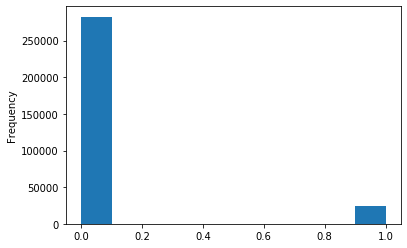

In [13]:
datasets["application_train"]['TARGET'].astype(int).plot.hist();

### Correlation of the target variable with the other variables:

In [14]:
correlations = datasets["application_train"].corr()['TARGET'].sort_values()
print('Most Positive Correlations:\n', correlations.tail(10))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64


The first glance at the ten positively and negatively correlated features tell us that none of them is strongly correlated. However, the most positively correlated feature is the age of the client, and the most negatively correlated features are the external sources (all three of them).

In [15]:
# Bad idea to visualize everything!

#df = datasets["application_train"]
#f = plt.figure(figsize=(19, 15))
#plt.matshow(df.corr(), fignum=f.number)
#plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
#plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=16);

### Applicants age distribution
To look at the age of the client feature, we need to construct a new variable using the _DAYS_BIRTH_ varaible.

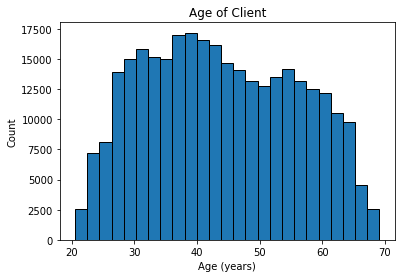

In [16]:
plt.hist(datasets["application_train"]['DAYS_BIRTH'] / -365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

### Applicants employment history
We also think that occupation might be an important criteria.

In [51]:
numeric_features = datasets['application_train'][[
    'AMT_INCOME_TOTAL',  'AMT_CREDIT','DAYS_EMPLOYED','DAYS_BIRTH','EXT_SOURCE_1',
    'EXT_SOURCE_2','EXT_SOURCE_3', 'TARGET']]
#g = sns.pairplot(numeric_features, hue="TARGET")

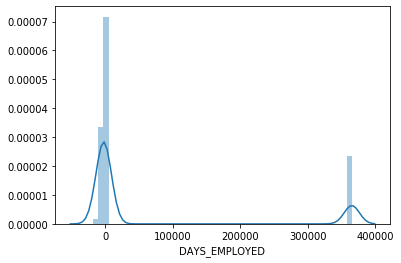

In [52]:
sns.distplot(numeric_features['DAYS_EMPLOYED']);
plt.show()

### Applicants occupation distribution

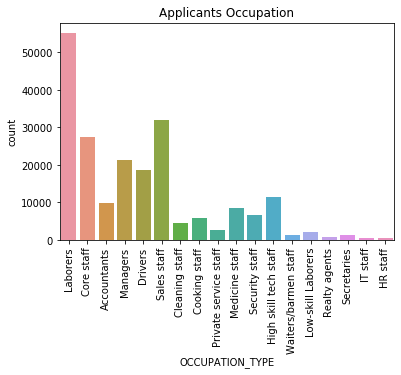

In [18]:
sns.countplot(x='OCCUPATION_TYPE', data=datasets["application_train"]);
plt.title('Applicants Occupation');
plt.xticks(rotation=90);
plt.show()

Occupation type counts in respect to the target variable.

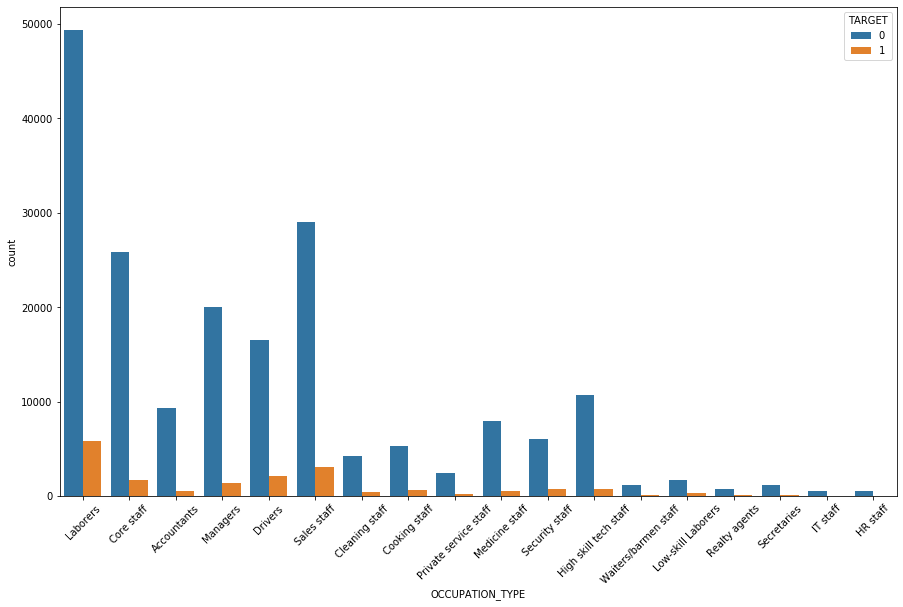

In [55]:
df = datasets['application_train'][['AMT_INCOME_TOTAL',  'AMT_CREDIT','DAYS_EMPLOYED','DAYS_BIRTH','EXT_SOURCE_1',
    'EXT_SOURCE_2','EXT_SOURCE_3', 'CODE_GENDER', 'FLAG_OWN_REALTY','FLAG_OWN_CAR','NAME_CONTRACT_TYPE', 
               'NAME_EDUCATION_TYPE','OCCUPATION_TYPE','NAME_INCOME_TYPE', 'TARGET']]
f, ax = plt.subplots(figsize=(15, 9))
g = sns.countplot(x="OCCUPATION_TYPE", hue="TARGET", data=df);
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.show();

### Amount of credit

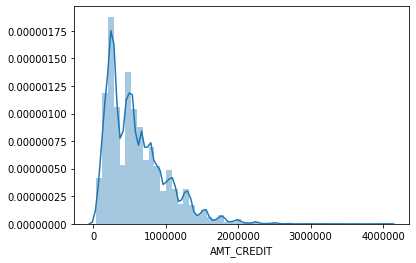

In [53]:
sns.distplot(numeric_features['AMT_CREDIT']);
plt.show();

### Education counts in respect to target.

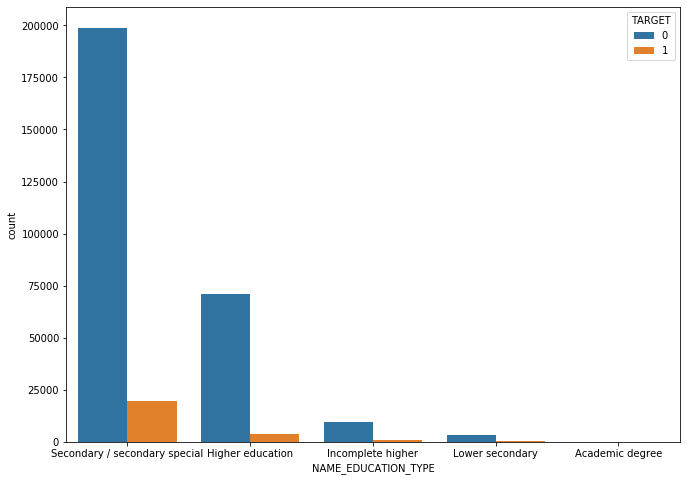

In [56]:
f, ax = plt.subplots(figsize=(11, 8))
g = sns.countplot(x="NAME_EDUCATION_TYPE", hue="TARGET", data=df);
#g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.show();

In [19]:
# TODO: need to link type of occupation and its history with target==0, and target==1. 

### Correlation matrix of numeric features

In [20]:
numeric_features = datasets['application_train'][[
    'AMT_INCOME_TOTAL',  'AMT_CREDIT','DAYS_EMPLOYED','DAYS_BIRTH','EXT_SOURCE_1',
    'EXT_SOURCE_2','EXT_SOURCE_3', 'TARGET']]
#g = sns.pairplot(numeric_features, hue="TARGET")
#plt.show()

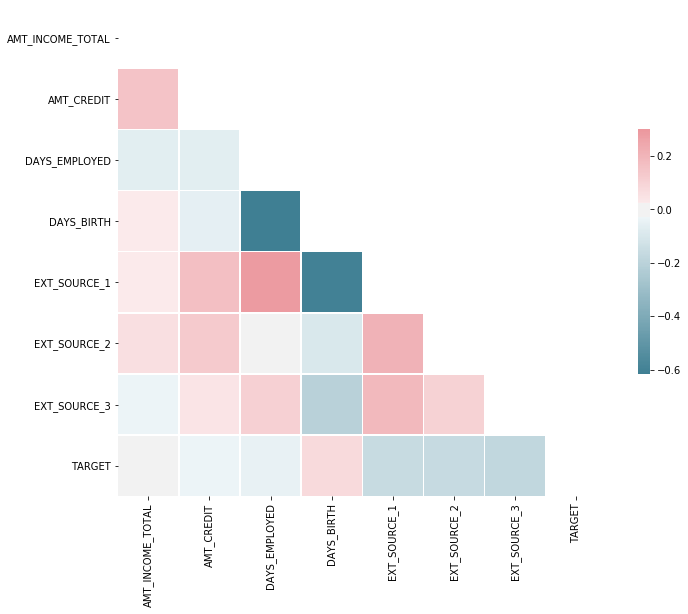

In [21]:
# Compute the correlation matrix
corr = numeric_features.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show();

In [22]:
### Other feature visualizations 

# Building processing pipeline
First, we select a subset of features based on their correlations with the target. Then we extract relevant data from _application_train_ and _application_test_ .

In [23]:
selected_features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'DAYS_EMPLOYED',
                     'DAYS_BIRTH','EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
                     'CODE_GENDER', 'FLAG_OWN_REALTY', 'FLAG_OWN_CAR',
                     'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE',
                     'OCCUPATION_TYPE', 'NAME_INCOME_TYPE']

X_train = datasets["application_train"][selected_features]
X_train['OCCUPATION_TYPE'] = X_train['OCCUPATION_TYPE'].apply(lambda x: 1. if x in ['Core Staff', 
                            'Accountants', 'Managers', 'Sales Staff', 'Medicine Staff', 
                            'High Skill Tech Staff', 'Realty Agents', 'IT Staff', 
                            'HR Staff'] else 0.)  

# test data for validating our training dataset 
y_train = datasets["application_train"]['TARGET']

# Unseen test data
X_kaggle_test = datasets["application_test"][selected_features]

In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   AMT_INCOME_TOTAL     307511 non-null  float64
 1   AMT_CREDIT           307511 non-null  float64
 2   DAYS_EMPLOYED        307511 non-null  int64  
 3   DAYS_BIRTH           307511 non-null  int64  
 4   EXT_SOURCE_1         134133 non-null  float64
 5   EXT_SOURCE_2         306851 non-null  float64
 6   EXT_SOURCE_3         246546 non-null  float64
 7   CODE_GENDER          307511 non-null  object 
 8   FLAG_OWN_REALTY      307511 non-null  object 
 9   FLAG_OWN_CAR         307511 non-null  object 
 10  NAME_CONTRACT_TYPE   307511 non-null  object 
 11  NAME_EDUCATION_TYPE  307511 non-null  object 
 12  OCCUPATION_TYPE      307511 non-null  float64
 13  NAME_INCOME_TYPE     307511 non-null  object 
dtypes: float64(6), int64(2), object(6)
memory usage: 32.8+ MB


In [25]:
y_train.head()

0    1
1    0
2    0
3    0
4    0
Name: TARGET, dtype: int64

In [26]:
X_kaggle_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AMT_INCOME_TOTAL     48744 non-null  float64
 1   AMT_CREDIT           48744 non-null  float64
 2   DAYS_EMPLOYED        48744 non-null  int64  
 3   DAYS_BIRTH           48744 non-null  int64  
 4   EXT_SOURCE_1         28212 non-null  float64
 5   EXT_SOURCE_2         48736 non-null  float64
 6   EXT_SOURCE_3         40076 non-null  float64
 7   CODE_GENDER          48744 non-null  object 
 8   FLAG_OWN_REALTY      48744 non-null  object 
 9   FLAG_OWN_CAR         48744 non-null  object 
 10  NAME_CONTRACT_TYPE   48744 non-null  object 
 11  NAME_EDUCATION_TYPE  48744 non-null  object 
 12  OCCUPATION_TYPE      33139 non-null  object 
 13  NAME_INCOME_TYPE     48744 non-null  object 
dtypes: float64(5), int64(2), object(7)
memory usage: 5.2+ MB


## Feature engineering


In [27]:
# Transforming features to log approximations (via pipeline)
class featureTransformer1(BaseEstimator, TransformerMixin):
    def __init__(self, features=None): # no *args or **kargs
        self.features = features
    def fit(self, X, y=None):
        return self
    def transform(self, X): 
        df = pd.DataFrame(X, columns=self.features)
#         X['EXT_SOURCE_1_2'] = [v**2 for v in X['EXT_SOURCE_1']]
#         X['EXT_SOURCE_2_2'] = [v**2 for v in X['EXT_SOURCE_2']]
#         X['EXT_SOURCE_3_2'] = [v**2 for v in X['EXT_SOURCE_3']]
        df['EXT_SOURCE_1_2'] = df['EXT_SOURCE_1'].apply(lambda x: x**2)
        df['EXT_SOURCE_2_2'] = df['EXT_SOURCE_2'].apply(lambda x: x**2)
        df['EXT_SOURCE_3_2'] = df['EXT_SOURCE_3'].apply(lambda x: x**2)
        df['CREDIT_AMT_RATIO'] = np.divide(df['AMT_CREDIT'], df['AMT_INCOME_TOTAL'])
        return np.array(df.values)

In [28]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [29]:
# Identify the numeric features we wish to consider. 
num_attribs = [
    'AMT_INCOME_TOTAL',  'AMT_CREDIT','DAYS_EMPLOYED','DAYS_BIRTH','EXT_SOURCE_1',
    'EXT_SOURCE_2','EXT_SOURCE_3']

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy='mean')),
        ('std_scaler', StandardScaler()),
        ("featureTransformer1", featureTransformer1(features=num_attribs)),
    ])
# Identify the categorical features we wish to consider.
cat_attribs = ['CODE_GENDER', 'FLAG_OWN_REALTY','FLAG_OWN_CAR','NAME_CONTRACT_TYPE', 
               'NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE']

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])

data_prep_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline)
    ])

In [30]:
#list(datasets["application_train"].columns)

## Preparing training, validation and test dataset

In [31]:
# Split the provided training data into training and validationa and test
# The kaggle evaluation test set has no labels
#

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
# y_test = datasets["application_test"]['TARGET']   #why no  TARGET?!! (hint: kaggle competition)
    
print(f"X train           shape: {X_train.shape}")
print(f"X validation      shape: {X_valid.shape}")
print(f"X test            shape: {X_test.shape}")
print(f"X X_kaggle_test   shape: {X_kaggle_test.shape}")

X train           shape: (222176, 14)
X validation      shape: (46127, 14)
X test            shape: (39208, 14)
X X_kaggle_test   shape: (48744, 14)


# Baseline Models

In [32]:
#def pct(x):
#    return round(100*x,3)

In [33]:
expLog = pd.DataFrame(columns=["exp_name", 
                                   "Train Acc", 
                                   "Valid Acc",
                                   "Test  Acc",
                                   "Train AUC", 
                                   "Valid AUC",
                                   "Test  AUC"
                                  ])

In [34]:
%%time 
np.random.seed(42)
full_pipeline_with_predictor = Pipeline([
        ("preparation", data_prep_pipeline),
        ("linear", LogisticRegression())
    ])
model = full_pipeline_with_predictor.fit(X_train, y_train)

CPU times: user 1min 16s, sys: 17.1 s, total: 1min 34s
Wall time: 1min 3s


In [35]:
np.round(accuracy_score(y_train, model.predict(X_train)), 3)

0.92

In [36]:
exp_name = f"Base Line Logistic Regression {len(selected_features)}_features"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model.predict(X_train)), 
                accuracy_score(y_valid, model.predict(X_valid)),
                accuracy_score(y_test, model.predict(X_test)),
                roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])],
    4)) 
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC
0,Base Line Logistic Regression 14_features,0.9198,0.9193,0.9159,0.7341,0.7345,0.7345


## Random forest (RF)

In [37]:
%%time 
np.random.seed(42)
full_pipeline_with_predictor = Pipeline([
        ("preparation", data_prep_pipeline),
        ("rf", RandomForestClassifier())
    ])
model = full_pipeline_with_predictor.fit(X_train, y_train)

CPU times: user 1min 51s, sys: 884 ms, total: 1min 52s
Wall time: 1min 51s


### RF accuracy

In [38]:
np.round(accuracy_score(y_train, model.predict(X_train)), 3)

1.0

### RF evaluation metrics

### RF evaluation on test and validation data

In [39]:
exp_name = f"Random_Forest_{len(selected_features)}_features"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model.predict(X_train)), 
                accuracy_score(y_valid, model.predict(X_valid)),
                accuracy_score(y_test, model.predict(X_test)),
                roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])],
    4)) 
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC
0,Base Line Logistic Regression 14_features,0.9198,0.9193,0.9159,0.7341,0.7345,0.7345
1,Random_Forest_14_features,1.0000,0.9189,0.9162,1.0000,0.7108,0.7108


## XGBoost

In [40]:
from xgboost import XGBClassifier

xgb = xgb.XGBClassifier(objective="binary:logistic", val_metric="auc", random_state=42, 
                        n_estimator=20, nthread=4)

xgb_model = Pipeline([
    ("preparation", data_prep_pipeline),
    ("classifier", xgb)
])

#xgb_model = xgb_with_pipeline.fit(X_train, y_train)

#y_pred = xgb_model.predict(X_train)

#print(confusion_matrix(y_train, y_pred))


### Hyperparameter search

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

params = {
    "classifier__max_depth": range(2, 10, 4),
    "classifier__n_estimators": range(60, 220, 80),
    "classifier__learning_rate": [0.3, 0.1, 0.1],
    "classifier__subsample": [0.3, 0.5, 0.7]
}

search = GridSearchCV(xgb_model, param_grid=params, cv=3, n_jobs=-1,
                      scoring = 'roc_auc', return_train_score=True)

search.fit(X_train, y_train)

report_best_scores(search.cv_results_, 1)


In [ ]:
np.round(accuracy_score(y_train, search.predict(X_test)), 3)

### XGBoost model evaluation

In [ ]:
exp_name = f"XGBoost_{len(selected_features)}_features"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, xgb_model.predict(X_train)), 
                accuracy_score(y_valid, xgb_model.predict(X_valid)),
                accuracy_score(y_test, xgb_model.predict(X_test)),
                roc_auc_score(y_train, xgb_model.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])],
    4)) 
expLog